In [10]:
!pip install dlib


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [11]:
!pip install timm


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [12]:
!pip install opencv-python


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [18]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import dlib
import cv2
from timm import create_model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 1: Data Loader Setup
def create_dataloaders(base_dir, batch_size=16):
    train_dataset = AugmentedImageDataset(os.path.join(base_dir, 'train'))
    val_dataset = AugmentedImageDataset(os.path.join(base_dir, 'validate'), augment=False)
    test_dataset = AugmentedImageDataset(os.path.join(base_dir, 'test'), augment=False)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, val_loader, test_loader

# Step 2: Face Detection with dlib
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

def detect_face_and_crop(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    if len(faces) == 0:
        return None
    
    face = faces[0]  # Assuming one face per image
    landmarks = predictor(gray, face)

    # Getting the coordinates of the left and right eye
    left_eye = (landmarks.part(36).x, landmarks.part(36).y)
    right_eye = (landmarks.part(45).x, landmarks.part(45).y)
    
    # Calculating the angle between the eyes
    dY = right_eye[1] - left_eye[1]
    dX = right_eye[0] - left_eye[0]
    angle = np.degrees(np.arctan2(dY, dX))  # Calculate the rotation angle in degrees

    # Gets the center of the eyes
    eyes_center = ((left_eye[0] + right_eye[0]) // 2, (left_eye[1] + right_eye[1]) // 2)

    # Gets the rotation matrix
    M = cv2.getRotationMatrix2D(eyes_center, angle, 1.0)

    # Rotating the image around the center of the eyes
    rotated_image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_CUBIC)

    # Recomputing the face bounding box after rotation
    gray_rotated = cv2.cvtColor(rotated_image, cv2.COLOR_BGR2GRAY)
    faces_rotated = detector(gray_rotated)
    if len(faces_rotated) == 0:
        return None
    
    face_rotated = faces_rotated[0]
    x, y, w, h = face_rotated.left(), face_rotated.top(), face_rotated.width(), face_rotated.height()

    # Including some part of the background by adding a margin around the face
    margin = int(0.2 * w)  
    x_min = max(0, x - margin)
    y_min = max(0, y - margin)
    x_max = min(rotated_image.shape[1], x + w + margin)
    y_max = min(rotated_image.shape[0], y + h + margin)
    
    cropped_image = rotated_image[y_min:y_max, x_min:x_max]
    return cropped_image

# Step 3: To check and Adjust Image Size
def resize_if_needed(image):
    required_size = (299, 299)
    if image.shape[:2] != required_size:
        image = cv2.resize(image, required_size)
    return image

# Step 4: Class to execute above methods
class AugmentedImageDataset(datasets.ImageFolder):
    def __init__(self, root, augment=True):
        super(AugmentedImageDataset, self).__init__(root)
        self.augment = augment

    def __getitem__(self, index):
        image, label = super(AugmentedImageDataset, self).__getitem__(index)
        image = np.array(image)
        
        # Detect face and crop
        cropped_image = detect_face_and_crop(image)
        if cropped_image is not None:
            image = cropped_image
        
        # Ensure the image is the correct size
        image = resize_if_needed(image)
        
        # Convert to tensor
        image = transforms.ToTensor()(image)
        
        return image, label

# Step 5: Xception Model and Grad-CAM Setup
class XceptionBinaryClassifier(nn.Module):
    def __init__(self):
        super(XceptionBinaryClassifier, self).__init__()
        self.model = create_model('xception', pretrained=True)
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.model.get_classifier().in_features, 1),
            nn.BatchNorm1d(1),
            nn.Sigmoid()
            
        )

    def forward(self, x):
        return self.model(x)

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.device = next(model.parameters()).device
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.target_activations = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        layer = dict([*self.model.named_modules()])[self.target_layer]
        layer.register_forward_hook(forward_hook)
        layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, class_idx=None):
        self.model.eval()
        input_tensor = input_tensor.to(self.device)

        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = torch.argmax(output, dim=1)

        self.model.zero_grad()
        one_hot_output = torch.FloatTensor(output.shape).zero_().to(self.device)
        one_hot_output[0][class_idx] = 1
        output.backward(gradient=one_hot_output, retain_graph=True)

        gradients = self.gradients.cpu().data.numpy()[0]
        target = self.target_activations.cpu().data.numpy()[0]
        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros(target.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * target[i]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (299, 299))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

    def overlay_cam(self, img, cam, alpha=0.5):
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        img = np.float32(img) / 255
        cam_img = heatmap * alpha + img * (1 - alpha)
        cam_img = cam_img / np.max(cam_img)
        return np.uint8(255 * cam_img)

def visualize_gradcam(grad_cam, data_loader, num_images=2):
    data_iter = iter(data_loader)
    for _ in range(num_images):
        images, labels = next(data_iter)
        images, labels = images.to(device), labels.to(device)

        cam = grad_cam.generate_cam(images)
        img = images[0].cpu().numpy().transpose(1, 2, 0)
        img = np.uint8(255 * (img * 0.5 + 0.5))  # Unnormalize
        cam_img = grad_cam.overlay_cam(img, cam)

        plt.figure(figsize=(8, 8))
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(cam_img)
        plt.title('Grad-CAM')
        plt.show()


Epoch 1/10, Train Loss: 0.5297, Train Acc: 75.69%, Val Loss: 0.5161, Val Acc: 78.48%
Epoch 2/10, Train Loss: 0.3981, Train Acc: 90.88%, Val Loss: 0.4866, Val Acc: 81.46%
Epoch 3/10, Train Loss: 0.3685, Train Acc: 94.46%, Val Loss: 0.4671, Val Acc: 83.33%
Epoch 4/10, Train Loss: 0.3526, Train Acc: 96.50%, Val Loss: 0.4629, Val Acc: 83.33%
Epoch 5/10, Train Loss: 0.3423, Train Acc: 97.45%, Val Loss: 0.4572, Val Acc: 85.23%
Epoch 6/10, Train Loss: 0.3337, Train Acc: 98.34%, Val Loss: 0.4558, Val Acc: 84.44%
Epoch 7/10, Train Loss: 0.3270, Train Acc: 98.83%, Val Loss: 0.4480, Val Acc: 85.35%
Epoch 8/10, Train Loss: 0.3266, Train Acc: 98.94%, Val Loss: 0.4445, Val Acc: 85.47%
Epoch 9/10, Train Loss: 0.3209, Train Acc: 99.16%, Val Loss: 0.4490, Val Acc: 85.27%
Epoch 10/10, Train Loss: 0.3165, Train Acc: 99.50%, Val Loss: 0.4431, Val Acc: 85.43%


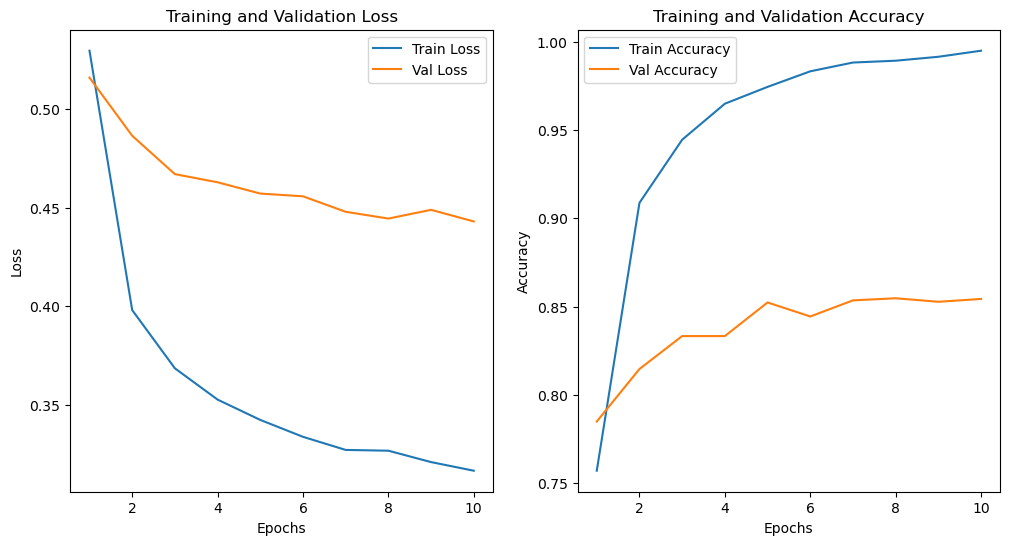

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


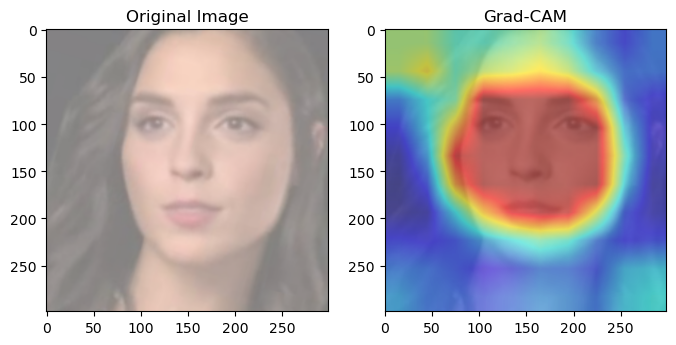

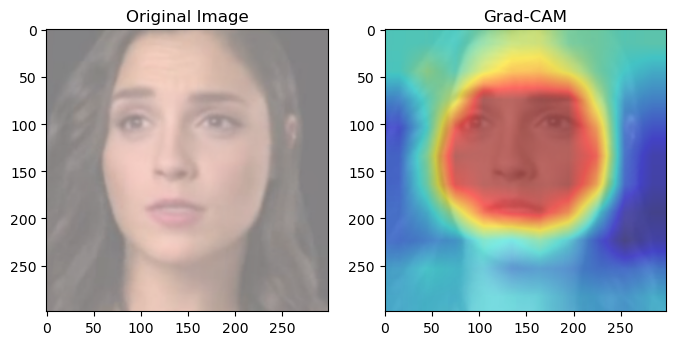

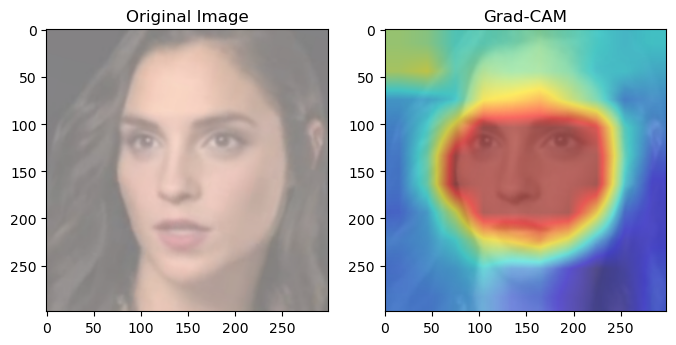

Accuracy on test set: 89.31%
Confusion Matrix:


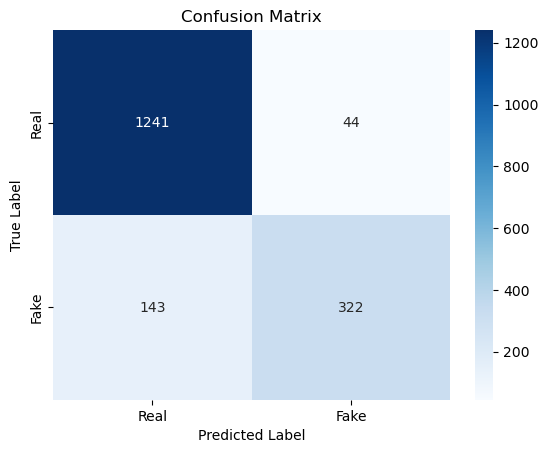

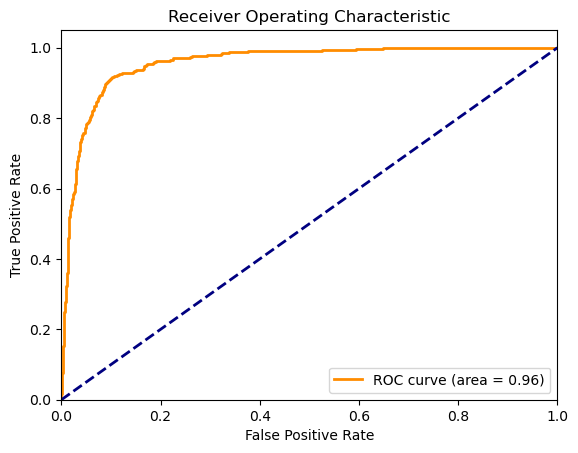

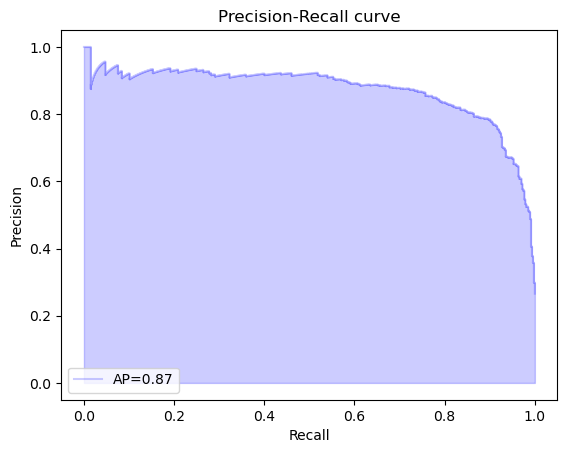

Model saved successfully!


In [19]:
# Training function with validation
def train_model(model, train_loader, val_loader, epochs=10, lr=0.00001, device=device):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            predicted = torch.round(outputs)
            correct += (predicted.squeeze() == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        train_accuracy = correct / total
        train_accuracies.append(train_accuracy)

        val_loss, val_accuracy, _, _ = evaluate_model(model, val_loader, device, is_train=False)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy*100:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy*100:.2f}%")
    
    # Plotting
    epochs_range = range(1, epochs + 1)
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    
    plt.show()

# Evaluation function
def evaluate_model(model, data_loader, device=torch.device('cpu'), is_train=True):
    model.eval()
    y_true = []
    y_pred = []
    y_scores = []  # To store probabilities for ROC and Precision-Recall curves
    running_loss = 0.0
    criterion = nn.BCELoss()

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device).float()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            predicted = torch.round(outputs)
            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())
            y_scores.extend(outputs.tolist())  # Keep the raw output for ROC and PR curves

    accuracy = accuracy_score(y_true, y_pred)
    avg_loss = running_loss / len(data_loader)
    
    if is_train:
        print(f"Accuracy on test set: {accuracy * 100:.2f}%")
        print("Confusion Matrix:")
        plot_confusion_matrix(y_true, y_pred)

    return avg_loss, accuracy, y_true, y_scores

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Plot ROC curve
def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Plot Precision-Recall curve
def plot_precision_recall_curve(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    average_precision = average_precision_score(y_true, y_scores)

    plt.figure()
    plt.step(recall, precision, where='post', color='b', alpha=0.2, label='AP={0:0.2f}'.format(average_precision))
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.legend(loc="lower left")
    plt.show()

base_dir = '/home/jovyan/DeepFakeDetection/Celeb-DF/Data/'
train_loader, val_loader, test_loader = create_dataloaders(base_dir)
model = XceptionBinaryClassifier()
train_model(model, train_loader, val_loader, device=device)

# Use Grad-CAM to visualize what the model is focusing on
grad_cam = GradCAM(model, target_layer='model.conv4')
visualize_gradcam(grad_cam, test_loader, num_images=3)

# Final evaluation on the test set
test_loss, test_accuracy, y_true, y_scores = evaluate_model(model, test_loader, device, is_train=True)

plot_roc_curve(y_true, y_scores)
plot_precision_recall_curve(y_true, y_scores)

torch.save(model.state_dict(), 'advance_model.pth')
print("Model saved successfully!")


In [33]:
import torch
from torchvision import transforms
import cv2
import numpy as np

# Loading the trained model
model = XceptionBinaryClassifier()
model.load_state_dict(torch.load('advance_model.pth'))
model.eval()
model.to(device)


def preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image not found or unreadable")
    
    # Detecting face and cropping 
    cropped_image = detect_face_and_crop(image)
    if cropped_image is not None:
        image = cropped_image

    
    image = resize_if_needed(image)

    # Converting to tensor
    transform = transforms.ToTensor()
    image_tensor = transform(image).unsqueeze(0)  
    return image_tensor

# Function to predict if an image is real or fake
def predict_image(image_path):
    image_tensor = preprocess_image(image_path).to(device)
    with torch.no_grad():
        output = model(image_tensor)
        prediction = torch.round(output).item()  # Get binary prediction (0 or 1)
        if prediction == 1:
            print("The image is Real")
        else:
            print("The image is Fake")


image_path = '/home/jovyan/DeepFakeDetection/Celeb-DF/ImageFake.png'  
predict_image(image_path)


The image is Fake
